/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Isochrone generation took 2.690134 s.
Making photometry for isochrone: log(t) = 6.00  AKs = 0.70  dist = 4500
     Starting at:  2025-02-04 05:20:35.551971   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F162M = 23.11
Starting filter: jwst,F182M   Elapsed time: 1.63 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F182M = 23.10
Starting filter: jwst,F200W   Elapsed time: 3.23 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F200W = 22.85
Starting filter: jwst,F356W   Elapsed time: 4.83 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F356W = 21.59
Starting filter: jwst,F405N   Elapsed time: 6.51 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F405N = 21.25
      Time taken: 8.25 seconds
Isochrone generation took 2.401187 s.
Making photometry for isochrone: log(t) = 6.18  AKs =

      Time taken: 3.31 seconds
Changing to logg=5.00 for T=  1893 logg=3.97
Isochrone generation took 1.300145 s.
Making photometry for isochrone: log(t) = 6.74  AKs = 0.70  dist = 4500
     Starting at:  2025-02-04 05:21:29.285621   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1893 K  m_jwst_F162M = 24.77
Starting filter: jwst,F182M   Elapsed time: 0.65 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1893 K  m_jwst_F182M = 24.98
Starting filter: jwst,F200W   Elapsed time: 1.31 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1893 K  m_jwst_F200W = 24.60
Starting filter: jwst,F356W   Elapsed time: 1.95 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1893 K  m_jwst_F356W = 22.96
Starting filter: jwst,F405N   Elapsed time: 2.63 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1893 K  m_jwst_F405N = 22.60
      Time taken: 3.32 seconds
Changing to log

Starting filter: jwst,F356W   Elapsed time: 2.23 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1602 K  m_jwst_F356W = 23.46
Starting filter: jwst,F405N   Elapsed time: 3.21 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1602 K  m_jwst_F405N = 23.04
      Time taken: 4.03 seconds
Changing to logg=5.00 for T=  1571 logg=4.05
Isochrone generation took 1.153996 s.
Making photometry for isochrone: log(t) = 7.00  AKs = 0.70  dist = 4500
     Starting at:  2025-02-04 05:22:10.804773   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1571 K  m_jwst_F162M = 26.30
Starting filter: jwst,F182M   Elapsed time: 0.68 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1571 K  m_jwst_F182M = 25.95
Starting filter: jwst,F200W   Elapsed time: 1.37 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1571 K  m_jwst_F200W = 25.52
Starting filter: jwst,F356W   Elapsed time: 2.

/tmp/ipykernel_26610/3762120629.py:85: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(level_ages, masses[0], chi_square_values.T, levels=[0.01], colors=[color], linewidths=2.5)


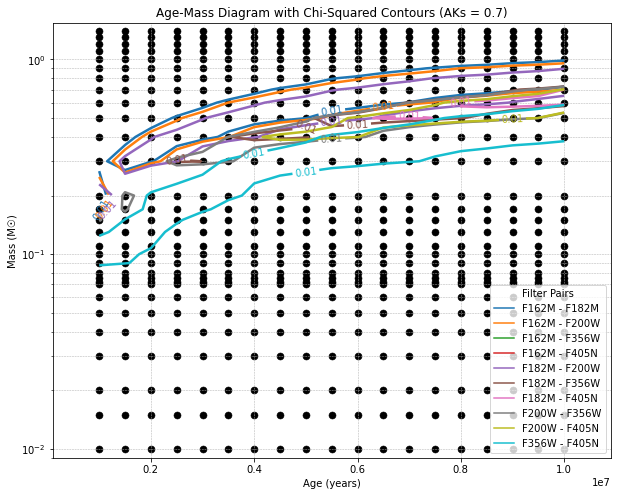

In [1]:
import os
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
from spisea import synthetic, evolution, atmospheres, reddening
from spisea.imf import imf, multiplicity
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import csv

# Paths for isochrones and output
iso_dir = 'isochrones/'
# output_dir = 'output_diagrams/'

# Estimation variables
star_index = 0      # Set which star in the CSV to analyze

# Define isochrone parameters
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawCardelli(3.1)
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W', 'jwst,F356W', 'jwst,F405N']
filters = ['m_jwst_F162M', 'm_jwst_F182M', 'm_jwst_F200W', 'm_jwst_F356W', 'm_jwst_F405N']
metallicity = 0
level_ages = np.linspace(1, 10, 19) * 1e6  # Define age array
log_age_arr = np.log10(level_ages)

# Change this as necessary
AKs = 0.7

# Load sample magnitudes, skipping the header row
sample_mags = []
with open('../../s284-no-errors.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for lines in csvFile:
        sample_mags.append([float(x) for x in lines])

# Ensure directories exist
os.makedirs(iso_dir, exist_ok=True)
# os.makedirs(output_dir, exist_ok=True)

# Clear previous isochrones
for file in os.listdir(iso_dir):
    os.remove(os.path.join(iso_dir, file))

# Generate isochrone grid
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Extract mass values for each isochrone
masses = np.array([[star['mass'] for star in iso.points] for iso in instances])

# Chi-square minimization function
def chi_square_analysis(iso_grid, sample_mags, f1, f2):
    chi_square_grid = np.zeros((len(iso_grid), len(iso_grid[0].points)))
    for i, iso in enumerate(iso_grid):
        for j, star in enumerate(iso.points):
            chi_square_grid[i, j] = sum(((sample_mags[k] - star[f]) ** 2) / star[f] for k, f in enumerate([f1, f2]))
    return chi_square_grid

# Generate all possible filter pairs
filter_pairs = [(filters[i], filters[j]) for i in range(len(filters)) for j in range(i+1, len(filters))]

# Colors for contour plots
colors = plt.cm.tab10(np.linspace(0, 1, len(filter_pairs)))

# Plot setup
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_yscale('log')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Mass (M☉)')
ax.set_title(f'Age-Mass Diagram with Chi-Squared Contours (AKs = {AKs})')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Iterate over filter pairs and plot contours
for (f1, f2), color in zip(filter_pairs, colors):
    chi_square_values = chi_square_analysis(instances, sample_mags[0], f1, f2)
    contour = ax.contour(level_ages, masses[0], chi_square_values.T, levels=[0.01], colors=[color], linewidths=2.5)
    ax.clabel(contour, inline=True, fontsize=10)
    ax.plot([], [], color=color, label=f"{f1.replace('m_jwst_', '')} - {f2.replace('m_jwst_', '')}")

# Scatter plot of isochrone grid points
sc = ax.scatter(
    np.repeat(level_ages, masses.shape[1]), 
    masses.flatten(), s=50, color='k', edgecolor='k', linewidth=0.5)

# Adjust axis limits
x_padding = 0.1 * (level_ages[-1] - level_ages[0])
y_padding_factor = 0.1
ax.set_xlim(level_ages[0] - x_padding, level_ages[-1] + x_padding)
ax.set_ylim(np.min(masses) * (1 - y_padding_factor), np.max(masses) * (1 + y_padding_factor))

# Add legend
ax.legend(title="Filter Pairs", fontsize=10, loc='lower right')

plt.show()

# Save the figure
# plt.savefig(os.path.join(output_dir, f'Age_Mass_AKs_{AKs}.png'))
# plt.close()
